<a href="https://colab.research.google.com/github/tomcaputo/aws_product_embeddings/blob/main/Self_Attention_Sequential_Recommendation_(SASRec).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Product Embedddings with the Amazon 2023

Questions
- How to handle max length of context window



TODO
- MLFlow logging
- test and train script
- How to update model with new users with transfer learning
- Loss must ignore padding


## Retrieval - algorithm scales well: focused on recall
Supervised
- Matrix Factorization
- NCF
- Two Towers

Embed --> VectorDB --> Retrieve via similarity

## Reranker -- employ more sophisticed models: focused on precision
- Transformer
- XGBoost



## Notebook Setup

In [6]:
!pip install faiss-gpu
!pip install datasets #evaluate torch
!pip install pytorch-lightning

In [7]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

import json
import copy

from datasets import load_dataset

import faiss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

from sklearn.preprocessing import LabelEncoder

In [8]:
sys.path.append("/content/drive/MyDrive/Colab Notebooks/RAG/")
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/RAG/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [21]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 1


## Amazon 2023 data set


The Amazon Reviews 2023 dataset, collected to ensure up-to-date training corpora for LLMs, is significantly more extensive than its predecessors. It contains millions of reviews with accompanying text, ratings, and timestamps, making it ideal for benchmarking recommender systems.


*   It features 3.18 times more items and 2.4 times more reviews and metadata

*   The metadata is richer and cleaner, parsed from HTML into JSON, with more descriptive fields and multi-modal content such as videos and images

  [Full Description](https://amazon-reviews-2023.github.io/)

There are two files that are used:



1.   `amazon_2023_full.parquet`: contains reviews
2.   `amazon_2023_metadata.parquet`: contains metadata on products



## Import Data

In [22]:

# Load interaction data
download_interaction_data = False
if download_interaction_data:
  interaction_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Books", trust_remote_code=True)
  print(interaction_dataset["full"][0])
  interaction_dataset["full"].to_parquet(data_dir + 'amazon_2023_full.parquet')

create_downsmaple = False
if create_downsmaple:
  interaction_df = pd.read_parquet(data_dir + 'amazon_2023_full.parquet')
  downsample_frac = .005

  # identify downsample IDs
  user_ids = pd.Series(interaction_df['user_id']).unique()
  rand_ids = np.random.uniform(0, 1, len(user_ids))
  user_ids = pd.Series(user_ids[rand_ids < downsample_frac])

  # downsample
  interaction_df[interaction_df['user_id'].isin(user_ids)].to_parquet(data_dir + 'amazon_2023_downsampled.parquet')

interaction_df = pd.read_parquet(data_dir + 'amazon_2023_downsampled.parquet')


In [23]:
interaction_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,1610585135448,0,True
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1542813324549,0,True
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1482324158000,0,True
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1416085800000,1,True
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1361917994000,2,True


In [24]:
download_metadata = False
if download_metadata:
  metadata_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Books", trust_remote_code=True)
  print(metadata_dataset["full"][0])
  metadata_dataset["full"].to_parquet(data_dir + 'amazon_2023_metadata.parquet')

create_downsmaple = False
if create_downsmaple:
  metadata_df = pd.read_parquet(data_dir + 'amazon_2023_metadata.parquet')

  # identify downsample IDs
  item_ids = pd.Series(interaction_df['parent_asin']).unique()

  # downsample
  metadata_df[metadata_df['parent_asin'].isin(item_ids)].to_parquet(data_dir + 'amazon_2023_metadata_downsampled.parquet')

metadata_df = pd.read_parquet(data_dir + 'amazon_2023_metadata_downsampled.parquet')

## EDA

In [25]:
print(f"""users: {interaction_df.user_id.nunique()}
items: {interaction_df.asin.nunique()}""")

users: 51611
items: 113753


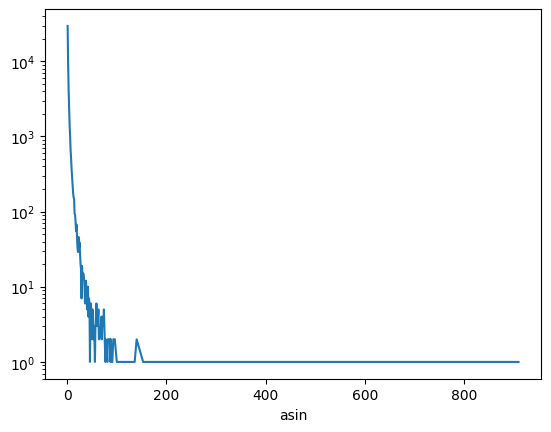

In [26]:
# unique products purchased per user
per_user_engagement = interaction_df.groupby('user_id')['asin'].count().value_counts().sort_index()
per_user_engagement.plot()
plt.yscale('log')

<Axes: xlabel='asin'>

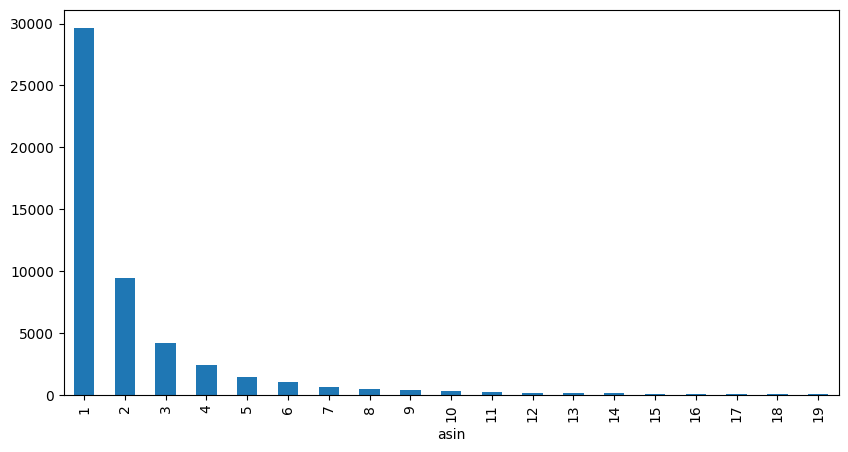

In [27]:
per_user_engagement[per_user_engagement.index<20].plot(kind='bar', figsize=(10, 5))

In [28]:
interaction_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,1610585135448,0,True
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1542813324549,0,True
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1482324158000,0,True
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1416085800000,1,True
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1361917994000,2,True


In [29]:
metadata_df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
2,Books,Service: A Navy SEAL at War,4.7,3421,"[Marcus Luttrell, author of the #1 bestseller,...","[Review, Praise for SERVICE""An action-packed.....",17.17,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}","Marcus Luttrell (Author), James D. Hornfischer","[Books, Biographies & Memoirs, Leaders & Notab...","{""Publisher"": ""Little, Brown and Company; 1st ...",0316185361,None,"Hardcover – May 8, 2012",{'avatar': 'https://m.media-amazon.com/images/...
7,Books,Make: Electronics: Learning Through Discovery,4.7,1366,"[""This is teaching at its best!"", Hans Camenzi...","[From the Author, Make: Electronics, is the bo...",13.43,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Charles Platt (Author),"[Books, Engineering & Transportation, Engineer...","{""Publisher"": ""Make Community, LLC; 2nd editio...",1680450263,None,2nd Edition,{'avatar': 'https://m.media-amazon.com/images/...
51,Books,I Hadn't Meant to Tell You This,4.8,61,[Twelve-year-old Marie is a leader among the p...,"[Amazon.com Review, Two girls: one white, one ...",2.09,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Jacqueline Woodson (Author),"[Books, Children's Books, Geography & Cultures]","{""Publisher"": ""Laurel Leaf (November 1, 1995)""...",0440219604,None,"Mass Market Paperback – November 1, 1995",{'avatar': 'https://m.media-amazon.com/images/...
93,Books,"Modern Fishing Lure Collectibles, Vol. 3: Iden...",4.3,10,"[Like Volumes 1 and 2, Modern Fishing Lure Col...","[Review, The great variety of fishing lures wi...",22.25,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Russell E. Lewis (Author),"[Books, Crafts, Hobbies & Home, Antiques & Col...","{""Publisher"": ""Collector Books; First Edition ...",1574324225,None,"Hardcover – Illustrated, October 15, 2004",{'avatar': 'https://m.media-amazon.com/images/...
105,Books,Looking for Peyton Place: A Novel,4.4,976,[The death of her mother brings award-winning ...,"[From Publishers Weekly, With her mother decea...",9.63,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Barbara Delinsky (Author),"[Books, Literature & Fiction, Contemporary]","{""Publisher"": ""Scribner; First Edition (July 1...",0743246446,None,"Hardcover – July 12, 2005",{'avatar': 'https://m.media-amazon.com/images/...


## Feature Engineering

In [34]:
# convert price to numerical
metadata_df['price'] = metadata_df['price'].str.replace('[^0-9\.]', '', regex=True)\
                                .replace('', np.nan).astype(float)\
                                .fillna(0)

AttributeError: Can only use .str accessor with string values!

In [33]:
features = ['average_rating', 'rating_number', 'price']

## SASRec

### Sequentialize Data

In [35]:
run_once=0
if run_once == 0:
  interaction_df['timestamp_unix'] = interaction_df['timestamp']
  run_once=1

seq_df = interaction_df.copy()
seq_df['timestamp'] = pd.to_datetime(seq_df['timestamp_unix'], unit='ms')

cols = ['rating', 'asin', 'timestamp', 'user_id']

seq_df['is_valid'] = seq_df.timestamp >= '2023-05-01'
seq_df = seq_df[seq_df.timestamp>'2010-01-01']
seq_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,timestamp_unix,is_valid
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,2021-01-14 00:45:35.448,0,True,1610585135448,False
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,2018-11-21 15:15:24.549,0,True,1542813324549,False
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,2016-12-21 12:42:38.000,0,True,1482324158000,False
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,2014-11-15 21:10:00.000,1,True,1416085800000,False
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,2013-02-26 22:33:14.000,2,True,1361917994000,False


In [36]:
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

seq_df['user_id'] = user_encoder.fit_transform(seq_df['user_id'])
seq_df['asin'] = product_encoder.fit_transform(seq_df['asin'])



<ipython-input-36-c617345da4f0>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x : x[:10] if len(x)>=10 else [0]*(max_len-len(x)) + x)


In [39]:
# Like the paper I take an explicit feedback approach and consider all actions but not reviews.
# Reviews can be represented in a seperate explicit feedback embedding but the paper notes that this did not improve their performance
#seq_df['success_purchase'] = (seq_df['rating'] > 3) & (seq_df['rating'])

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,timestamp_unix,is_valid
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],42496,1338252801,37652,2021-01-14 00:45:35.448,0,True,1610585135448,False
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],707,0060853964,22642,2018-11-21 15:15:24.549,0,True,1542813324549,False
6296,5.0,👍🏽,👍🏽,[],25933,0761169083,22642,2016-12-21 12:42:38.000,0,True,1482324158000,False
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],58837,1561380792,22642,2014-11-15 21:10:00.000,1,True,1416085800000,False
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],10691,0345803485,22642,2013-02-26 22:33:14.000,2,True,1361917994000,False


In [50]:
# sequentialize
cols = ['user_id', 'timestamp', 'asin']
seq_df_gp = seq_df[cols].sort_values('timestamp').groupby('user_id').agg(list).reset_index()

# padding
max_len = 10
seq_df_gp[['asin','timestamp']] = seq_df_gp[['asin','timestamp']].\
                                            applymap(lambda x : x)

<ipython-input-50-ba8d31b420bd>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x : x)


In [51]:
seq_df_gp.head()

,user_id,timestamp,asin
0,0,"[2013-12-21 05:06:34, 2015-07-11 14:15:05]","[88945, 65230]"
1,1,"[2013-06-16 14:29:07, 2018-08-04 00:50:15.685000]","[83572, 91628]"
2,2,"[2013-08-21 00:03:46, 2016-12-18 21:45:36, 202...","[20673, 54125, 78922]"
3,3,"[2015-02-04 20:28:44, 2015-03-01 17:56:05, 201...","[75993, 62508, 60312]"
4,4,[2013-10-05 14:16:28],[62270]


In [66]:
# filter out users with only 1 purchase
seq_df_gp = seq_df_gp[seq_df_gp['asin'].apply(lambda x: len(x) > 1)]
seq_df_gp.shape

(20405, 3)

In [155]:
class seqDataset(Dataset):
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def pad_clip(self, x):
      pad_length = self.max_len - len(x)
      if pad_length>0:
        x = F.pad(x, (0, pad_length), value=0)
      else:
        x = x[:self.max_len]
      return x

    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        user_id = torch.tensor(data['user_id'])
        labels = torch.tensor(data['asin'])[1:]
        product_id = torch.tensor(data['asin'][:-1])

        # pad
        product_id = self.pad_clip(product_id)
        labels = self.pad_clip(labels)

        #labels = torch.tensor(data['asin'])
        #target_rating = torch.tensor(data['asin'][-1])


        return user_id, product_id, labels

In [156]:
dataset = seqDataset(seq_df_gp, max_len=10)

In [157]:
dataset.__getitem__(49)

(tensor(121),
 tensor([53736,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([96360,     0,     0,     0,     0,     0,     0,     0,     0,     0]))

### Model Architecture

In [226]:
class PlTrainer(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.criterion = nn.CrossEntropyLoss(ignore_index=0)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=.001)
    return optimizer

  def common_step(self, batch, batch_idx):
    user_id, product_id, y = batch
    y_hat = self.forward(user_id, product_id) # batch, seq_len, token

    # stop point
    y_hat = y_hat.view(-1, y_hat.size(2))  # batch, seq_len, token --> batch*seq_len, token
    y = y.view(-1)  # batch, seq_len --> batch*seq_len

    loss = self.criterion(y_hat, y)

    return loss

  def training_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

In [227]:
class SaveMetricsCallback(pl.Callback):

    def __init__(self):
      super().__init__()
      self.metrics = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the logs directly from the logger
        each_me = copy.deepcopy(trainer.callback_metrics['train_loss']).cpu().numpy()
        self.metrics.append(each_me)
        print(f"Epoch {trainer.current_epoch}: {trainer.callback_metrics}")

In [228]:
class SASRec(PlTrainer):
    def __init__(self, n_tokens, d_model=32,
                 num_heads=2, num_layers=2, dropout=0.1, max_len=10):
        super(SASRec, self).__init__()

        # P x d_model
        self.product_embedding = nn.Embedding(n_tokens, d_model, padding_idx=0) # seq_len, d_model -- embeddings are calculated on the last dimension
        self.position_embedding = nn.Embedding(max_len, d_model) # seq_len x d_model -- learnable position embedding

        self.emb_dropout = nn.Dropout(dropout)

        self.transformer_encoder = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=num_heads,
                                                   dim_feedforward = d_model,
                                                   dropout=dropout, batch_first=True) # batch, seq_len, d_model

        self.fc = nn.Linear(d_model, n_tokens)
        self.max_len = max_len


    def forward(self, user_id, product_ids):

        src_mask = torch.triu(torch.full((self.max_len, self.max_len), float('-inf')), diagonal=1)
        src_mask = src_mask.to(product_ids.device)
        positions = torch.arange(product_ids.size(1)).to(product_ids.device).unsqueeze(0).expand_as(product_ids) # batch, seq_len -- expand_as to match batch size
        position_embeddings = self.position_embedding(positions) # batch, seq_len --> batch, seq_len, d_model

        product_embeddings = self.product_embedding(product_ids) # batch, seq_len --> batch, seq_len, d_model

        embeddings = product_embeddings + position_embeddings

        embeddings = self.emb_dropout(embeddings)

        # src_mask: seq_len , seq_len
        transformer_out = self.transformer_encoder(embeddings, src_mask=src_mask) # batch, seq_len, d_model --> batch, seq_len, d_model

        logits = self.fc(transformer_out) # batch, seq_len, d_model --> batch, seq_len, tokens
        out = F.sigmoid(logits)
        return out

### Training Loop

In [232]:
callback = SaveMetricsCallback()
trainer = pl.Trainer(max_epochs=10, callbacks=[callback])

n_items = interaction_df.asin.nunique()
embedding_size = 16

train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

SASRec_model = SASRec(n_tokens=n_items, d_model=64,
                      num_heads=2, num_layers=1, dropout=.1, max_len=10)

trainer.fit(SASRec_model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                    | Params | Mode 
------------------------------------------------------------------------
0 | criterion           | CrossEntropyLoss        | 0      | train
1 | product_embedding   | Embedding               | 7.3 M  | train
2 | position_embedding  | Embedding               | 640    | train
3 | emb_dropout         | Dropout                 | 0      | train
4 | transformer_encoder | TransformerEncoderLayer | 25.2 K | train
5 | fc                  | Linear                  | 7.4 M  | train
------------------------------------------------------------------------
14.7 M   

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: {'train_loss': tensor(11.6523, device='cuda:0')}
Epoch 1: {'train_loss': tensor(11.4538, device='cuda:0')}
Epoch 2: {'train_loss': tensor(11.2894, device='cuda:0')}
Epoch 3: {'train_loss': tensor(11.1738, device='cuda:0')}
Epoch 4: {'train_loss': tensor(11.0779, device='cuda:0')}
Epoch 5: {'train_loss': tensor(10.9975, device='cuda:0')}
Epoch 6: {'train_loss': tensor(10.9331, device='cuda:0')}
Epoch 7: {'train_loss': tensor(10.8830, device='cuda:0')}
Epoch 8: {'train_loss': tensor(10.8432, device='cuda:0')}
Epoch 9: {'train_loss': tensor(10.8111, device='cuda:0')}


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
t.permute(1,0,2).size()

torch.Size([100, 10, 1000])

## Bert4Rec

## Sequential Model

In [ ]:
class seq_Dataset(Dataset):
  def __init__(self, cust_behavior, context_window=10)

    self.context_window = context_window
    self.product_features =
    self.cust_behavior = cust_behavior
    self.parent_idx = parent_idx_tensor

  def pad_df(self, cust_behavior):
    data = {}
    for col


  def __getitems__(self, idx):
    feature_token = self.get_values

In [ ]:
#interaction_df.sort_values('timestmap', ascending=False).groupby('user_id')['rating'].apply(lambda x: x)

In [ ]:
interaction_df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,1610585135448,0,True
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1542813324549,0,True
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1482324158000,0,True
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1416085800000,1,True
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1361917994000,2,True
...,...,...,...,...,...,...,...,...,...,...
29474574,5.0,Daughter loved it,My daughter hugged the books on Christmas morn...,[],1454903597,1454903597,AF4K4X523XERW6VAM7TONCFJXTZQ,1388592808000,0,True
29474605,5.0,Oh Brothers!,Another terrific tale from Robert Ferrigno. N...,[],0375401253,0375401253,AF66SYN54HL2HK5T3JWPF4G4ZLVQ,1012375362000,0,False
29474606,4.0,Bourne again?,I enjoyed this book. Partially because it was...,[],0385479611,0385479611,AF66SYN54HL2HK5T3JWPF4G4ZLVQ,1012374866000,2,False
29474710,5.0,Five Stars,Fun class,[],1449697208,1449697208,AHHXPDYK3IVYF3ALMXZQT2VPSGZQ,1431893209000,0,True


In [177]:
class PlTrainer(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.criterion = F.binary_cross_entropy

  def configure_callbacks(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=.001)
    return optimizer

  def common_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x, causal=True)

    # stop point
    y_hat = y_hat.reshape((len(y_hat)*y_hat.shape[1], y_hat.shape[-1]))
    y = y.reshape((len(y)*y.shape[1], y.shape[-1]))
    ind = x['strt_ind'].view(-1) == True

    y_hat = y_hat[ind]
    y = y[ind]

    y_hat = y_hat[:, 1:]
    y = y[:, 1:]


    loss = self.criterion(y_hat, y)

    return loss

  def training_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

In [178]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int,
                  droupout: float=.1, max_len: int=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe) # registers for as part of model state, nontrainable parameter

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [179]:
class TabTransformer(pl.LightningModule):
  def __init__(self, num_items, d_model, nhead,
               num_encoder_layers, dim_feedforward,
               max_len, dropout=0.1):
    self.d_model = d_model
    self.contextual_embedding = nn.TransformerEncoderLayer(
        d_model, nhead, dim_feedforward, dropout
    )

  def forward(self, x: list):
    xs = []
    b,t,c, = x[0].shape

    for feature in x:
      xs.append(feature.reshape((b*t, 1, c)))

    xs = torch.concatenate(xs, dim=1)
    xs = self.contextual_embedding(xs)
    xs = xs.reshape((b, t, c*len(x)))
    return xs

In [180]:
class TransformerModel(PlTrainer):
  # embed seperately, then layer norm, # more dim for contexxtual dim,
  # multiple laters for self attention, layernorm, a couple linear layers to shrink size to final output


  def __init__(self, num_items, d_model, nhead,
                num_encoder_layers, dim_feedforward,
                max_len, dropout=0.1):
      super().__init__()
      self.item_embedding = nn.Embedding(num_items, d_model)
      self.position_embedding = PositionalEncoding(d_model, max_len)
      self.transformer_encoder = nn.TransformerEncoder(
          nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout),
          num_encoder_layers
      )
      self.norm = nn.LayerNorm(d_model)
      self.linear = nn.Linear(d_model, num_items)
      self.dropout = nn.Dropout(dropout)
      self.d_model = d_model

  @classmethod
  def from_pretrained(cls, PATH):

    params = json.load(open(PATH + '/params.json', 'r'))
    model = cls(**params)
    model.load_state_dict(torch.load(PATH+ '/model.json'))
    model.__dict__.update(params)
    model.params.update(params)
    return model

  def forward(self, src, src_mask):
      src = self.item_embedding(src) * np.sqrt(self.d_model)
      src = self.position_embedding(src)
      output = self.transformer_encoder(src)
      output = self.linear(output)


      # embedding layers
      self.norm(self.apex(src['apex']))

      # seasonal embeddings
      torch.sin(2*3.14*src['dow']/7)
      torch.cos(2*3.14*src['dow']/7)

      seasonal_embed = torch.cat([...])
      self.norm(self.seasonal_embed(seasonal_em))

      # SASRec
      item_em = self.product_embedding(src['seq'][:, :, -1]) #3d to 2D token embeddings
      item_em = self.prod_encoder(item_em) + seasonal_em
      item_encoded = self.item_encoder(item_em, src_mask=src_mask)


      item_encoded = self.item_encoder(item_em, src_mask=src_mask) + item_em # why add this back in?

      ft_em = self.contextual_em([...])
      output = self.norm(ft_em)
      output = self.linear(output)

      return output

  def save(self, PATH=None):
    """
    Save model to PATH
    """

    if not os.path.exists(PATH):
      os.makedirs(PATH)

    torch.save(self.state_dict(), PATH + '/model.json')
    params = {}

    for key, value in self.__dict__.items():
      if type(value) in (type('s'), type(1), type(1.)):
        params.update({key:value})
    json.dump(params, open(PATH + '/params.json', 'w'))
    self.params.updates(params)

## BERT from Scratch


Also build `TransformerEncoderLayer` from scratch

In [ ]:
vocab_size = 30000
n_segments = 3
max_len = 512
embedding_dim = 768
n_layers = 12
attn_heads = 12
dropout = .1

class BERTEmbedding(nn.Module):
  def __init__(self, vocab_size, n_segments, max_len, embedding_dim, dropout):
    super().__init__()

    self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
    self.seg_embedding = nn.Embedding(n_segments, embedding_dim)
    self.position_embedding = nn.Embedding(max_len, embedding_dim)

    self.drop = nn.Dropout(dropout)
    self.pos_inp = torch.tensor([i for i in range(max_len)])


  def forward(self, seq, seg):
    embed_val = self.token_embedding(seq) + self.seg_embedding(seg) + self.position_embedding(self.pos_inp)
    return embed_val

class BERT(nn.Module):
  def __init__(self,
               vocab_size,
               n_segments,
               max_len,
               embedding_dim,
               n_layers,
               attn_heads,
               dropout):
    super().__init__()

    self.embedding = BERTEmbedding(vocab_size, n_segments, max_len, embedding_dim, dropout)
    self.encoder_layer= nn.TransformerEncoderLayer(embedding_dim, attn_heads, embed_dim=4)
    self.encoder_block = nn.TransformerEncoder(self.encoder_layer, n_layers

  def forward(self, seq, seg):
    embed_val = self.embedding(seq, seg)
    output = self.encoder_block(embed_val

In [ ]:
sample_seq = torch.randint(high=vocab_size, size=[max_len])
sample_seg = torch.randint(high=n_segments, size=[max_len])

embedding = BERTEmbedding(vocab_size, n_segments, max_len, embedding_dim, n_layers, attn_heads, dropout)
embedding_tensor = embedding(sample_seq, sample_seg)

print(embedding_tensor.size())

torch.Size([512, 768])


## Coding from scratch

In [ ]:
import torch
import torch.nn
import numpy as np

In [ ]:
torch.arange(0, 10, dtype=torch.float).unsqueeze(1)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [ ]:
class InputEmbeddings(nn.Module):

  def __init__(self, d_model: int, vocab_size: int):
    super().__init__():
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * np.sqrt(self.d_model) # avoid saturating the softmax


class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, dropout: float=.1, seq_len: int=5000):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    # shape seq_len, d_model
    pe = torch.zeros(self.seq_len, self.d_model)
    position = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-np.log(10000.0) / self.d_model))

  def forward(self, x):



In [ ]:
#exploring positon embedding

In [ ]:
vocab x seq



position = np.arange(0, 100)
np.ones((100, 20))

pe = position/10000**()
